In [1]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'torwic':
    os.chdir('../..')
print(os.getcwd())

/mnt/C45ADD865ADD7620/i3d-rrc/ic-topo-nav/mickst3r


In [2]:
from scipy.spatial import KDTree
dataset_root = Path("./data/TorWIC-SLAM")

image_type = "image_right"
scene_day = "Jun15"
ref_scene_run = "Hallway_Full_CCW"
query_scene_run = "Aisle_CCW_Run_1"

ref_traj_file = Path("./data/gt_image_right_poses_tum_ref.txt")
ref_gt_poses = ref_traj_file.read_text().splitlines()
ref_gt_poses_array = np.array([list(map(float, pose.split())) for pose in ref_gt_poses])
ref_kd_tree = KDTree(ref_gt_poses_array[:, 1:3])

ref_image_folder = dataset_root / scene_day / ref_scene_run / image_type
ref_image_files = natsorted(list(ref_image_folder.glob("*.png")))

query_traj_file = Path("./data/gt_image_right_poses_tum_query_down.txt")
query_gt_poses = query_traj_file.read_text().splitlines()
query_gt_poses_array = np.array([list(map(float, pose.split())) for pose in query_gt_poses])

query_image_folder = dataset_root / scene_day / query_scene_run / image_type
query_image_files = natsorted(list(query_image_folder.glob("*.png")))
query_image_files = query_image_files[::10]

assert len(ref_image_files) == len(ref_gt_poses_array)
assert len(query_image_files) == len(query_gt_poses_array)

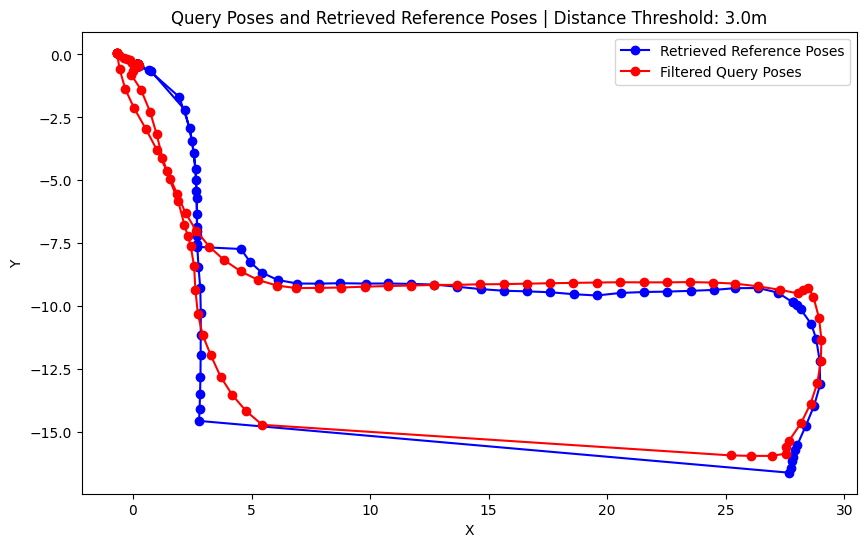

In [3]:
# Loop over all query images and retrieve the nearest reference pose
DIST_THRESHOLD = 3.0

retrieved_ref_poses = []
filtered_query_poses = []
for query_pose in query_gt_poses_array:
    distance, ref_idx = ref_kd_tree.query(query_pose[1:3])  # Using tx, ty, tz for querying
    if distance < DIST_THRESHOLD:  # Skip if the nearest pose is 3m or further
        ref_pose = ref_gt_poses_array[ref_idx]
        retrieved_ref_poses.append(ref_pose)
        filtered_query_poses.append(query_pose)

# Convert lists to numpy arrays for easier plotting
filtered_query_positions = np.array(filtered_query_poses)[:, 1:3]  # Assuming the poses are in columns 1 to 3
retrieved_ref_positions = np.array(retrieved_ref_poses)[:, 1:3]  # Assuming the poses are in columns 1 to 3

# Plot the query poses and retrieved reference poses
plt.figure(figsize=(10, 6))

plt.plot(retrieved_ref_positions[:, 0], retrieved_ref_positions[:, 1], 'bo-', label='Retrieved Reference Poses')
plt.plot(filtered_query_positions[:, 0], filtered_query_positions[:, 1], 'ro-', label='Filtered Query Poses')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Query Poses and Retrieved Reference Poses | Distance Threshold: {DIST_THRESHOLD}m') 
plt.legend()

plt.show()

In [4]:
from mast3r_src.model import AsymmetricMASt3R

from dust3r_src.dust3r.inference import inference
from dust3r_src.dust3r.utils.image import load_images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_name = "./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

Using device: cuda
... loading model from ./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [5]:
import cv2
def backproject_3d(uv, depth, K):
    '''
    Backprojects 2d points given by uv coordinates into 3D using their depth values and intrinsic K
    :param uv: array [N,2]
    :param depth: array [N]
    :param K: array [3,3]
    :return: xyz: array [N,3]
    '''

    uv1 = np.concatenate([uv, np.ones((uv.shape[0], 1))], axis=1)
    xyz = depth.reshape(-1, 1) * (np.linalg.inv(K) @ uv1.T).T
    return xyz

class PnPSolver:
    '''Estimate relative pose (metric) using Perspective-n-Point algorithm (2D-3D) correspondences'''

    def __init__(self):
        # PnP RANSAC parameters
        self.ransac_iterations = 1000
        self.reprojection_inlier_threshold = 3
        self.confidence = 0.9999

    def estimate_pose(self, pts0, pts1, depth_0, K_common):
        # uses nearest neighbour
        pts0 = np.int32(pts0)

        if len(pts0) < 4:
            return np.full((3, 3), np.nan), np.full((3, 1), np.nan), 0

        # get depth at correspondence points
        depth_pts0 = depth_0[pts0[:, 1], pts0[:, 0]]

        # remove invalid pts (depth == 0)
        valid = depth_pts0 > depth_0.min()
        if valid.sum() < 4:
            return np.full((3, 3), np.nan), np.full((3, 1), np.nan), 0
        pts0 = pts0[valid]
        pts1 = pts1[valid].astype(np.float32)
        depth_pts0 = depth_pts0[valid]

        # backproject points to 3D in each sensors' local coordinates
        K0 = K_common
        K1 = K_common
        xyz_0 = backproject_3d(pts0, depth_pts0, K0)

        # get relative pose using PnP + RANSAC
        succ, rvec, tvec, inliers = cv2.solvePnPRansac(
            xyz_0, pts1, K1,
            None, iterationsCount=self.ransac_iterations,
            reprojectionError=self.reprojection_inlier_threshold, confidence=self.confidence,
            flags=cv2.SOLVEPNP_P3P)

        # refine with iterative PnP using inliers only
        if succ and len(inliers) >= 6:
            succ, rvec, tvec, _ = cv2.solvePnPGeneric(xyz_0[inliers], pts1[inliers], K1, None, useExtrinsicGuess=True, rvec=rvec, tvec=tvec, flags=cv2.SOLVEPNP_ITERATIVE)
            rvec = rvec[0]
            tvec = tvec[0]

        # avoid degenerate solutions
        if succ:
            if np.linalg.norm(tvec) > 1000:
                succ = False

        if succ:
            R, _ = cv2.Rodrigues(rvec)
            t = tvec.reshape(3, 1)
        else:
            R = np.full((3, 3), np.nan)
            t = np.full((3, 1), np.nan)
            inliers = []

        return R, t, len(inliers)

In [6]:
from mast3r_src.fast_nn import fast_reciprocal_NNs
from src.tf_utils import compose_qt_tf
device = 'cuda'

FILTERED_COUNT = len(filtered_query_poses)
image_gt_poses_list_kitti = []

for i in tqdm(range(FILTERED_COUNT)):
    image_q_path = query_image_files[int(filtered_query_poses[i][0])]
    image_r_path = ref_image_files[int(retrieved_ref_poses[i][0])]

    images = load_images([str(image_r_path), str(image_q_path)], size=512)
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']

    desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

    # find 2D-2D matches between the two images
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                    device=device, dist='dot', block_size=2**13)

    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
        matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
        matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

    valid_matches = valid_matches_im0 & valid_matches_im1
    matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

    depth_im0 = pred1['pts3d'][..., 2].squeeze(0).cpu().numpy()

    fx, fy, cx, cy = 613.100554293744, 613.903691840614, 638.086832160361, 378.314715743037
    K_common = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    # scale by 0.4 
    K_common = K_common * 0.4
    K_common[2, 2] = 1

    # run PnP solver
    solver = PnPSolver()
    R, t, inliers = solver.estimate_pose(matches_im0, matches_im1, depth_im0, K_common)
    
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t.squeeze()
    
    mast3r2torwic = np.array([[0, -1, 0, 0], [0, 0, -1, 0], [1, 0, 0, 0], [0, 0, 0, 1]])
    mast3r2torwic_alt = np.array([[0, 0, 1, 0], [-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
    
    T = T @ mast3r2torwic_alt
    
    # reference tranform
    retrieved_ref_pose = retrieved_ref_poses[i]
    qvec_ref = retrieved_ref_pose[4:]
    tvec_ref = retrieved_ref_pose[1:4]
    tf_ref= compose_qt_tf(qvec_ref, tvec_ref, fix_qvec=True)
    
    # transform from current reference (relative) to global by multiplying with reference pose
    T_transformed = tf_ref @ T
    
    image_gt_poses_list_kitti.append(T_transformed)

image_gt_poses_kitti = np.array([pose[:3, :].reshape(-1) for pose in image_gt_poses_list_kitti])
gt_poses_file_kitti = Path("./data") / 'pred_image_right_poses_kitti_query_down.txt'
np.savetxt(gt_poses_file_kitti, image_gt_poses_kitti, fmt='%.6f')
print(f'> Saved GT camera poses to {gt_poses_file_kitti}')

  0%|          | 0/94 [00:00<?, ?it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000072.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000000.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  1%|          | 1/94 [00:00<00:44,  2.08it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000072.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000010.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  2%|▏         | 2/94 [00:00<00:35,  2.62it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000072.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000020.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  3%|▎         | 3/94 [00:01<00:32,  2.84it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000072.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000030.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  4%|▍         | 4/94 [00:01<00:30,  2.96it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000072.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000040.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  5%|▌         | 5/94 [00:01<00:29,  3.04it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000007.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000050.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  6%|▋         | 6/94 [00:02<00:28,  3.08it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000042.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000060.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  7%|▋         | 7/94 [00:02<00:28,  3.07it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000073.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000070.png with resolution 1280x720 --> 512x288
 (Found 2 images)


  9%|▊         | 8/94 [00:02<00:28,  3.01it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000082.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000080.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 10%|▉         | 9/94 [00:03<00:29,  2.92it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000104.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000090.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 11%|█         | 10/94 [00:03<00:28,  2.91it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000123.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000100.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 12%|█▏        | 11/94 [00:03<00:28,  2.95it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000133.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000110.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 13%|█▎        | 12/94 [00:04<00:28,  2.85it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000145.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000120.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 14%|█▍        | 13/94 [00:04<00:28,  2.89it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000154.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000130.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 15%|█▍        | 14/94 [00:04<00:27,  2.90it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000167.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000140.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 16%|█▌        | 15/94 [00:05<00:26,  2.95it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000171.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000150.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 17%|█▋        | 16/94 [00:05<00:25,  3.00it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000175.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000160.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 18%|█▊        | 17/94 [00:05<00:25,  3.01it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000184.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000170.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 19%|█▉        | 18/94 [00:06<00:24,  3.06it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000193.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000180.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 20%|██        | 19/94 [00:06<00:24,  3.09it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000203.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000190.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 21%|██▏       | 20/94 [00:06<00:23,  3.11it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000212.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000200.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 22%|██▏       | 21/94 [00:07<00:24,  2.96it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000220.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000210.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 23%|██▎       | 22/94 [00:07<00:25,  2.80it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000229.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000220.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 24%|██▍       | 23/94 [00:07<00:25,  2.75it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000236.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000230.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 26%|██▌       | 24/94 [00:08<00:25,  2.76it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000242.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000240.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 27%|██▋       | 25/94 [00:08<00:25,  2.76it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000247.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000250.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 28%|██▊       | 26/94 [00:08<00:24,  2.81it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001102.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000460.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 29%|██▊       | 27/94 [00:09<00:23,  2.82it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001104.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000470.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 30%|██▉       | 28/94 [00:09<00:23,  2.82it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001107.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000480.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 31%|███       | 29/94 [00:10<00:23,  2.77it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001109.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000490.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 32%|███▏      | 30/94 [00:10<00:22,  2.80it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001112.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000500.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 33%|███▎      | 31/94 [00:10<00:21,  2.87it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001114.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000510.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 34%|███▍      | 32/94 [00:11<00:21,  2.95it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001123.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000520.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 35%|███▌      | 33/94 [00:11<00:20,  3.00it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001132.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000530.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 36%|███▌      | 34/94 [00:11<00:20,  2.99it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001142.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000540.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 37%|███▋      | 35/94 [00:12<00:19,  3.01it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001151.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000550.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 38%|███▊      | 36/94 [00:12<00:19,  2.99it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001160.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000560.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 39%|███▉      | 37/94 [00:12<00:19,  2.97it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001166.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000570.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 40%|████      | 38/94 [00:13<00:18,  2.98it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001173.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000580.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 41%|████▏     | 39/94 [00:13<00:18,  2.97it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001175.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000590.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 43%|████▎     | 40/94 [00:13<00:18,  2.95it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001177.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000600.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 44%|████▎     | 41/94 [00:14<00:18,  2.91it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001177.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000610.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 45%|████▍     | 42/94 [00:14<00:17,  2.90it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001184.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000620.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 46%|████▌     | 43/94 [00:14<00:17,  2.94it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001192.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000630.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 47%|████▋     | 44/94 [00:15<00:16,  2.99it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001202.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000640.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 48%|████▊     | 45/94 [00:15<00:16,  3.02it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001211.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000650.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 49%|████▉     | 46/94 [00:15<00:15,  3.01it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001221.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000660.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 50%|█████     | 47/94 [00:16<00:15,  2.96it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001231.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000670.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 51%|█████     | 48/94 [00:16<00:15,  2.99it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001241.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000680.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 52%|█████▏    | 49/94 [00:16<00:14,  3.01it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001251.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000690.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 53%|█████▎    | 50/94 [00:17<00:14,  3.02it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001299.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000700.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 54%|█████▍    | 51/94 [00:17<00:14,  3.02it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001309.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000710.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 55%|█████▌    | 52/94 [00:17<00:13,  3.03it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001319.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000720.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 56%|█████▋    | 53/94 [00:18<00:13,  2.96it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001329.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000730.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 57%|█████▋    | 54/94 [00:18<00:13,  2.98it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001339.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000740.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 59%|█████▊    | 55/94 [00:18<00:13,  3.00it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001349.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000750.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 60%|█████▉    | 56/94 [00:19<00:12,  3.01it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001359.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000760.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 61%|██████    | 57/94 [00:19<00:12,  3.03it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001369.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000770.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 62%|██████▏   | 58/94 [00:19<00:11,  3.05it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001379.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000780.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 63%|██████▎   | 59/94 [00:20<00:11,  3.06it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001391.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000790.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 64%|██████▍   | 60/94 [00:20<00:11,  3.07it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001401.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000800.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 65%|██████▍   | 61/94 [00:20<00:10,  3.08it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001412.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000810.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 66%|██████▌   | 62/94 [00:21<00:10,  3.06it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001432.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000820.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 67%|██████▋   | 63/94 [00:21<00:10,  3.06it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001442.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000830.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 68%|██████▊   | 64/94 [00:21<00:09,  3.09it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001451.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000840.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 69%|██████▉   | 65/94 [00:21<00:09,  3.10it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001459.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000850.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 70%|███████   | 66/94 [00:22<00:09,  3.05it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001466.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000860.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 71%|███████▏  | 67/94 [00:22<00:09,  2.94it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/001473.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000870.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 72%|███████▏  | 68/94 [00:23<00:08,  2.93it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000176.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000880.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 73%|███████▎  | 69/94 [00:23<00:08,  2.80it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000169.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000890.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 74%|███████▍  | 70/94 [00:23<00:08,  2.73it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000161.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000900.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 76%|███████▌  | 71/94 [00:24<00:08,  2.66it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000150.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000910.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 77%|███████▋  | 72/94 [00:24<00:08,  2.63it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000140.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000920.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 78%|███████▊  | 73/94 [00:24<00:07,  2.65it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000128.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000930.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 79%|███████▊  | 74/94 [00:25<00:07,  2.64it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000113.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000940.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 80%|███████▉  | 75/94 [00:25<00:07,  2.66it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000083.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000950.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 81%|████████  | 76/94 [00:26<00:06,  2.65it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000073.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000960.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 82%|████████▏ | 77/94 [00:26<00:06,  2.62it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000006.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000970.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 83%|████████▎ | 78/94 [00:26<00:06,  2.61it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000980.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 84%|████████▍ | 79/94 [00:27<00:05,  2.61it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000990.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 85%|████████▌ | 80/94 [00:27<00:05,  2.60it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001000.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 86%|████████▌ | 81/94 [00:28<00:04,  2.62it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001010.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 87%|████████▋ | 82/94 [00:28<00:04,  2.61it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001020.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 88%|████████▊ | 83/94 [00:28<00:04,  2.64it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001030.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 89%|████████▉ | 84/94 [00:29<00:03,  2.65it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001040.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 90%|█████████ | 85/94 [00:29<00:03,  2.64it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001050.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 91%|█████████▏| 86/94 [00:29<00:02,  2.72it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001060.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 93%|█████████▎| 87/94 [00:30<00:02,  2.73it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001070.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 94%|█████████▎| 88/94 [00:30<00:02,  2.83it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000044.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001080.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 95%|█████████▍| 89/94 [00:30<00:01,  2.94it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000062.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001090.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 96%|█████████▌| 90/94 [00:31<00:01,  3.02it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000062.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001100.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 97%|█████████▋| 91/94 [00:31<00:00,  3.08it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000062.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001110.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 98%|█████████▊| 92/94 [00:31<00:00,  3.14it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000062.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001120.png with resolution 1280x720 --> 512x288
 (Found 2 images)


 99%|█████████▉| 93/94 [00:32<00:00,  3.17it/s]

>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000062.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/001130.png with resolution 1280x720 --> 512x288
 (Found 2 images)


100%|██████████| 94/94 [00:32<00:00,  2.90it/s]

> Saved GT camera poses to data/pred_image_right_poses_kitti_query_down.txt
